In [0]:
!wget 'https://raw.githubusercontent.com/larrrry1412/larrrry1412.github.io/master/recog/model2/class_names.txt'

--2018-12-21 07:08:09--  https://raw.githubusercontent.com/larrrry1412/larrrry1412.github.io/master/recog/model2/class_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 822 [text/plain]
Saving to: ‘class_names.txt’

class_names.txt     100%[===================>]     822  --.-KB/s    in 0s      

2018-12-21 07:08:10 (83.9 MB/s) - ‘class_names.txt’ saved [822/822]



In [0]:
f = open("class_names.txt","r")
# 读数据
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data

In [0]:
#导入数据集
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bench.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/basketball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rifle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stop%20sign.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bed.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bread.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sword.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/key.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitma

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #初始化
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #加载data 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #打乱数据集
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #分为测试集和训练集 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [0]:
print(len(x_train))

320000


book


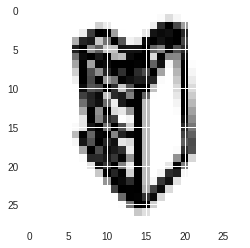

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# 更改图片size
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
#定义模型
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
#定义优化器
adam = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

In [0]:
#训练模型
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Epoch 1/5
 - 22s - loss: 1.9561 - top_k_categorical_accuracy: 0.7775 - val_loss: 1.4451 - val_top_k_categorical_accuracy: 0.8706
Epoch 2/5
 - 16s - loss: 1.2835 - top_k_categorical_accuracy: 0.8891 - val_loss: 1.2148 - val_top_k_categorical_accuracy: 0.8971
Epoch 3/5
 - 15s - loss: 1.1169 - top_k_categorical_accuracy: 0.9082 - val_loss: 1.1159 - val_top_k_categorical_accuracy: 0.9066
Epoch 4/5
 - 17s - loss: 1.0237 - top_k_categorical_accuracy: 0.9175 - val_loss: 1.0551 - val_top_k_categorical_accuracy: 0.9157
Epoch 5/5
 - 17s - loss: 0.9604 - top_k_categorical_accuracy: 0.9241 - val_loss: 1.0096 - val_top_k_categorical_accuracy: 0.9178


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 91.92%


['anvil', 'lightning', 'river', 'beach', 'snake']


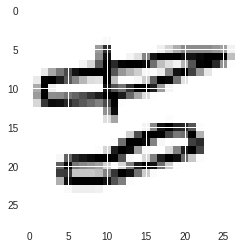

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

下载模型

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 13.9MB 2.7MB/s 
    100% |████████████████████████████████| 307kB 19.1MB/s 
    100% |████████████████████████████████| 61kB 20.8MB/s 
keras 2.2.2 has requirement keras-applications==1.0.4, but you'll have keras-applications 1.0.6 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.5 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Found existing installation: tensorflow-hub 0.2.0
    Uninstalling tensorflow-hub-0.2.0:
      Successfully uninstalled tensorflow-hub-0.2

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

Using TensorFlow backend.


In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1 (deflated 7%)
  adding: model/class_names.txt (deflated 41%)
  adding: model/model.json (deflated 83%)


In [0]:
from google.colab import files
files.download('model.zip')